In [1]:
import metnum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, clear_output
from tqdm.notebook import tnrange, tqdm

In [2]:
import numpy as np

def dist_coseno_matrix(X1, X2):
    X1_norm = np.linalg.norm(X1, axis=1, keepdims=True)
    X2_norm = np.linalg.norm(X2, axis=1, keepdims=True).T
    dot_product = np.dot(X1, X2.T)
    return 1 - dot_product / (X1_norm * X2_norm)


class KNNClassifier:
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.train_x = X
        self.labels = y

    def predict(self, X):
        distances = dist_coseno_matrix(X, self.train_x)
        sorted_indices = np.argsort(distances, axis=1)
        k_nearest_indices = sorted_indices[:,:self.n_neighbors]
        k_nearest_labels = self.labels[k_nearest_indices]
        moda = np.argmax(np.apply_along_axis(np.bincount, axis=1, arr=k_nearest_labels, minlength=k_nearest_labels.max()+1), axis=1)
        return moda

In [3]:
X_train = pd.read_csv("./datos/X_train.csv", header=None)[:4500]
y_train = pd.read_csv("./datos/y_train.csv", header=None)[:4500]
X_train=X_train.values
y_train=y_train.values

X_train_dev = pd.read_csv("./datos/X_train.csv", header=None)[4500:5000]
y_train_dev = pd.read_csv("./datos/y_train.csv", header=None)[4500:5000]
X_train_dev=X_train_dev.values
y_train_dev=y_train_dev.values


Ej 3.a

In [15]:
y_train.ravel()

array([0, 1, 2, ..., 7, 8, 9])

In [13]:
# Realizar un reconocedor de imagenes usando KNN para un k fijo de 5, usando los
# datos de entrenamiento dados y medir la performance con la medida de exactitud
# en el conjunto de prueba.

knn = KNNClassifier(5)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_train_dev)
accuracy = np.mean(y_pred == y_train_dev.ravel())
print(accuracy)

#TODO: preguntar si es suficiente.
# No tiene mucho sentido medir performance aislada

0.812


Ej 3.b

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, recall_score, precision_score
from time import time


def knn_K(k, X, y):
    k_fold = KFold(n_splits=5)
    k_fold.get_n_splits(X)

    accs, tiempos = ([] for i in range(2))

    #Se va variando la particion con la que se testea del K-Fold
    for train_index, test_index in k_fold.split(X):
        # Separamos el conjunto de entrenamiento y el conjunto de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cl = KNNClassifier(k)

        time_start = time()

        cl.fit(X_train, y_train)
        y_pred = cl.predict(X_test)

        time_end = time()

        accs.append(accuracy_score(y_test, y_pred))
        tiempos.append(time_end - time_start)

        

    accs = np.asarray(accs)
    tiempos = np.asarray(tiempos)

    return [accs,
            tiempos]


In [42]:
# TODO: Tomar el promedio de los k?
# Nos da que el mejor k es 1, ¿está bien?

k_list = np.arange(1, 50)

accs = []
tiempos = []
var_tiempo = []

for k in tqdm(k_list):
    ans = knn_K(int(k), X_train, y_train)

    accs.append(ans[0].mean())
    tiempos.append(ans[1].mean())
    var_tiempo.append(ans[1].std())


  0%|          | 0/49 [00:00<?, ?it/s]

In [45]:
accs.index(max(accs[1:]))


3

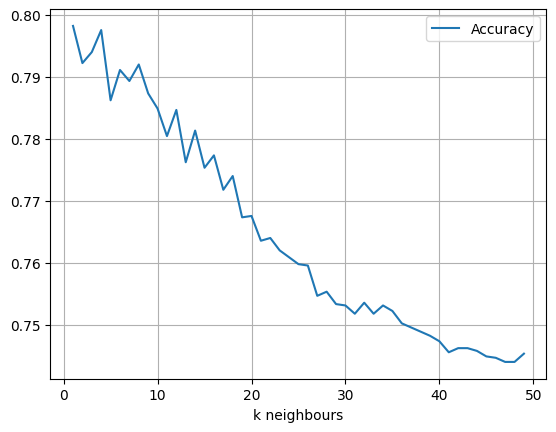

In [44]:
plt.plot(k_list, accs)
plt.grid()
plt.xlabel("k neighbours")
plt.ylabel("")
plt.legend(['Accuracy'])
plt.savefig("images/full-con-k.png")
plt.show()


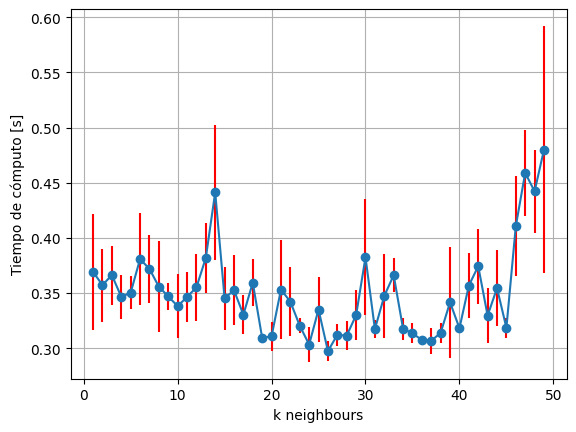

In [46]:
plt.figure("Tiempos con k")
plt.errorbar(k_list, tiempos, yerr=var_tiempo, fmt='-o', ecolor='red')
plt.grid()
plt.xlabel("k neighbours")
plt.ylabel("Tiempo de cómputo [s]")
plt.savefig("images/tiempos-con-k-var.png")
plt.show()

Ej 3.c

Preprocesar los datos de entrenamiento con PCA, usando la implementacion del
metodo de la potencia para encontrar los autovectores de la matriz de covarianza.
Visualizar la cantidad de varianza explicada en funcion de la cantidad de componentes p.

In [5]:
from sklearn.decomposition import PCA
import metnum
k = 15
p_list = np.arange(1, 10)

accs = []
res1 = []


for alpha in tqdm(p_list):


    pca1 = metnum.PCA(int(alpha))
    pca1.fit(X_train)
    X_trans = pca1.transform(X_train)
    res1.append(pca1.explained_variance())

    pca2 = PCA(n_components=int(alpha))
    pca2.fit(X_train)
    res2.append(pca2.explained_variance_)


res1

  0%|          | 0/9 [00:00<?, ?it/s]

[array([1.13735827e-06]),
 array([1.36977992e-06, 1.25666999e-05]),
 array([1.52977388e-06, 1.30356103e-05, 6.18485655e-05]),
 array([1.99175865e-06, 3.31357396e-05, 1.52003217e-04, 2.69800366e-04]),
 array([2.63834455e-06, 5.77580174e-05, 2.45022411e-04, 3.26603887e-04,
        5.49955801e-04]),
 array([8.01118363e-06, 5.88168145e-05, 2.57605053e-04, 6.18302475e-04,
        9.19684378e-04, 1.50544360e-03]),
 array([9.18777454e-06, 8.32599344e-05, 4.22274362e-04, 7.50292363e-04,
        1.28012472e-03, 2.21568296e-03, 2.90466608e-03]),
 array([9.20643340e-06, 8.32801754e-05, 4.22494369e-04, 7.60806856e-04,
        1.28283964e-03, 2.23155429e-03, 2.93669992e-03, 6.86156061e-03]),
 array([1.11849713e-05, 8.33044445e-05, 4.22842976e-04, 8.12728790e-04,
        1.41000811e-03, 2.70180628e-03, 3.61399210e-03, 7.50176270e-03,
        1.53701398e-02])]

In [ ]:
res

In [ ]:
k = 15
p_list = np.arange(1, 25)

accs = []
tiempos = []


for alpha in tqdm(p_list):

    time_start = time()

    pca = metnum.PCA(int(alpha))
    pca.fit(X_train)
    X_trans = pca.transform(X_train)
    time_end = time()
    tiempos.append(time_end- time_start)
    ans = knn_K(k, X_trans, y_train)
    accs.append(ans[0].mean())


# Variando el alfa de PCA

In [55]:
k = 15
alpha_list = np.arange(1, 25)

accs = []
tiempos = []
kappas = []
f1_scores = []
recalls = []
presicion = []

for alpha in tqdm(alpha_list):

    time_start = time()

    pca = metnum.PCA(int(alpha))
    pca.fit(X_train)

    X_trans = pca.transform(X_train)
    time_end = time()

    tiempos.append(time_end- time_start)
    
    ans = knn_K(k, X_trans, y_train)
    
    accs.append(ans[0].mean())
    # tiempos.append(ans[1].mean())
    kappas.append(ans[2].mean())
    f1_scores.append(ans[3].mean())
    recalls.append(ans[4].mean())
    presicion.append(ans[5].mean())

  0%|          | 0/24 [00:00<?, ?it/s]

/home/gonza/Downloads/testttt/tp2-metodos/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gonza/Downloads/testttt/tp2-metodos/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gonza/Downloads/testttt/tp2-metodos/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

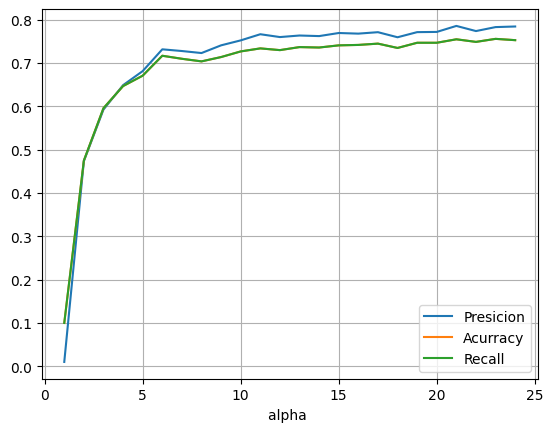

In [46]:
plt.plot(alpha_list, presicion) and plt.plot(alpha_list, accs) and plt.plot(alpha_list, recalls)
plt.grid()
plt.xlabel("alpha ")
plt.ylabel("")
plt.legend(['Presicion','Acurracy','Recall'])
plt.savefig("images/full-con-alpha.png")
plt.show()

In [53]:
tiempos

[-0.12618303298950195,
 -0.11747622489929199,
 -0.2349395751953125,
 -0.2417888641357422,
 -0.2904932498931885,
 -0.3056783676147461,
 -0.40204811096191406,
 -0.375903844833374,
 -0.5682291984558105,
 -0.58656907081604,
 -0.6774792671203613,
 -0.7354514598846436,
 -0.8111755847930908,
 -0.8862876892089844,
 -1.1752550601959229,
 -1.2085208892822266,
 -1.280351161956787,
 -1.379699945449829,
 -1.4810700416564941,
 -1.6047918796539307,
 -1.9961771965026855,
 -1.931361436843872,
 -2.2922251224517822,
 -2.3683714866638184]

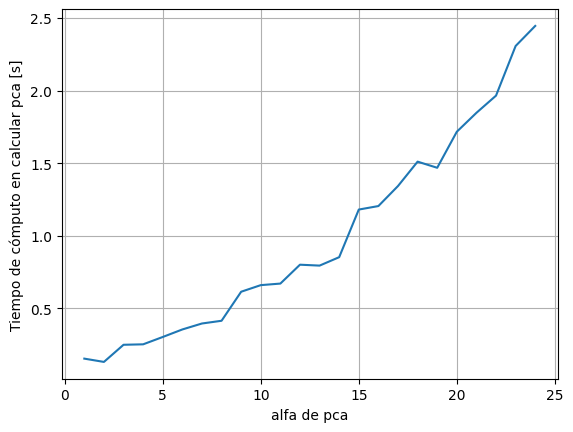

In [57]:
# TODO faltaria hacerle un promedio para este grafico
plt.figure("Tiempos con alfa") 
plt.plot(alpha_list, tiempos) #and plt.axhline(y=162)
plt.grid()
plt.xlabel("alfa de pca")
plt.ylabel("Tiempo de cómputo en calcular pca [s]")
plt.savefig("images/tiempos-con-alfa.png")
plt.show()